In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np

import random
#import memory_profiler
import altair as alt
from tqdm import tqdm
import datetime

USE_ALL_STOCK_IDS = False
TEST_SIZE = 0.25

import os
ENV_HOME = True
if os.environ.get('USER') == 'ian':
    import ipython_memory_usage
    %ipython_memory_usage_start
    USE_TEST_LOCAL_6_ITEMS = True # robust local testing at home
else:
    assert USE_ALL_STOCK_IDS, "Must use all stocks if on Kaggle platform"
    ENV_HOME = False
    USE_TEST_LOCAL_6_ITEMS = False
    # kaggle notes:
    # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
    # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 134.88 MiB


In [2]:
# OR PASTE IN UTILITY CODE HERE FOR KAGGLE
from utility import make_unique_time_ids, get_data, get_training_stock_ids
from utility import ROOT, TEST_CSV


Utility says ROOT is /home/ian/data/kaggle/optiver_volatility/
In [2] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 134.88 MiB


## Load train set

In [3]:
stock_ids = get_training_stock_ids('book_train.parquet') # all stocks by default
if not USE_ALL_STOCK_IDS:
    # choose a random subset
    print("Using a subset")
    random.shuffle(stock_ids)
    stock_ids = stock_ids[:30]
    print(stock_ids)

Using a subset
[64, 16, 69, 56, 68, 83, 87, 95, 30, 75, 119, 78, 0, 17, 104, 6, 31, 85, 34, 105, 81, 59, 14, 122, 108, 123, 118, 101, 67, 4]
In [3] used 0.3359 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 135.21 MiB


In [4]:
if 'df_train_all' not in dir():
    # only reload if necessary
    print(f"Loading {len(stock_ids)} stocks")
    df_train_all, df_book_train = get_data(stock_ids=stock_ids)
    
    df_train_all = df_train_all.set_index(['stock_id', 'time_id'])
    #df_train_all

Loading 30 stocks
There are 112 items in the folder and they look like ['stock_id=59', 'stock_id=58', 'stock_id=23', 'stock_id=17', 'stock_id=109']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.78it/s]


Loaded 45,641,526 rows for book_train on 30 stock_ids
**** Had 428,932 rows, now we have 114,899
In [4] used 3986.9922 MiB RAM in 5.31s, peaked 761.29 MiB above current, total RAM usage 4122.21 MiB


In [5]:
df_book_train

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,0.999847,1.000077,0.999693,1.000153,37,11,46,200,64
1,5,1,1.000077,1.000153,0.999847,1.000230,5,100,337,100,64
2,5,2,0.999847,1.000153,0.999693,1.000230,237,6,46,100,64
3,5,5,0.999847,1.000153,0.999693,1.000230,37,106,46,100,64
4,5,6,0.999923,1.000077,0.999847,1.000153,100,100,37,6,64
...,...,...,...,...,...,...,...,...,...,...,...
1073984,32767,580,0.999221,1.000035,0.999079,1.000301,100,100,25,9,4
1073985,32767,581,0.999221,1.000035,0.999079,1.000212,100,100,25,9,4
1073986,32767,582,0.999221,1.000035,0.999079,1.000212,100,108,25,9,4
1073987,32767,583,0.999221,1.000035,0.999079,1.000212,100,108,25,9,4


In [5] used -64.4766 MiB RAM in 0.14s, peaked 64.48 MiB above current, total RAM usage 4057.73 MiB


In [6]:
all_time_ids = df_book_train.time_id.unique()
np.random.shuffle(all_time_ids) # shuffle the time_ids
print(f"We have {len(all_time_ids):,} time ids")
time_ids_train, time_ids_test = make_unique_time_ids(all_time_ids, test_size=TEST_SIZE)
assert len(time_ids_train) + len(time_ids_test) == len(all_time_ids)
assert len(time_ids_train.intersection(time_ids_test)) == 0, "Expecting no overlap between train and test time ids"
print(f"Example time ids for training, min first: {sorted(list(time_ids_train))[:5]}")

We have 3,830 time ids
Taking 2872 for train
Example time ids for training, min first: [5, 11, 16, 31, 62]
In [6] used -268.4844 MiB RAM in 0.40s, peaked 235.15 MiB above current, total RAM usage 3789.25 MiB


In [7]:
df_train_all.sample(5)

,,target
stock_id,time_id,
118,14312,0.002191
67,15647,0.005844
118,6316,0.009636
78,20678,0.009242
16,22262,0.001439


In [7] used -103.9062 MiB RAM in 0.13s, peaked 103.91 MiB above current, total RAM usage 3685.34 MiB


In [8]:
df_train_all.reset_index()['time_id'].value_counts().describe()

count    3830.000000
mean       29.999739
std         0.016158
min        29.000000
25%        30.000000
50%        30.000000
75%        30.000000
max        30.000000
Name: time_id, dtype: float64

In [8] used -175.8516 MiB RAM in 0.11s, peaked 49.67 MiB above current, total RAM usage 3509.49 MiB


In [9]:
if USE_ALL_STOCK_IDS:
    assert len(stock_ids) == 112
    if not (df_train_all.groupby('time_id').count().max()[0] == 112 and \
      df_train_all.groupby('time_id').count().min()[0] == 111):
        display(df_train_all.groupby('time_id').count().agg(['max', 'min']))
        raise Warning('Odd! Expecting 111-112')

In [9] used -234.5508 MiB RAM in 0.13s, peaked 159.03 MiB above current, total RAM usage 3274.94 MiB


In [10]:
df_train_all.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 114899 entries, (0, 5) to (123, 32767)
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   target  114899 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB
In [10] used -64.2461 MiB RAM in 0.11s, peaked 64.25 MiB above current, total RAM usage 3210.69 MiB


In [11]:
df_train_all.head()

target
stock_id time_id          
0        5        0.004136
         11       0.001445
         16       0.002168
         31       0.002195
         62       0.001747

In [11] used -217.4297 MiB RAM in 0.11s, peaked 217.43 MiB above current, total RAM usage 2993.26 MiB


# Overview

In [12]:
print(df_train_all.shape)
df_train_all.head()

(114899, 1)


target
stock_id time_id          
0        5        0.004136
         11       0.001445
         16       0.002168
         31       0.002195
         62       0.001747

In [12] used -122.2266 MiB RAM in 0.12s, peaked 122.23 MiB above current, total RAM usage 2871.04 MiB


# Features

In [13]:
df_book_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45641526 entries, 0 to 1073988
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   time_id            int16  
 1   seconds_in_bucket  int16  
 2   bid_price1         float32
 3   ask_price1         float32
 4   bid_price2         float32
 5   ask_price2         float32
 6   bid_size1          int32  
 7   ask_size1          int32  
 8   bid_size2          int32  
 9   ask_size2          int32  
 10  stock_id           int64  
dtypes: float32(4), int16(2), int32(4), int64(1)
memory usage: 2.2 GB
In [13] used -29.0234 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 2842.01 MiB


In [14]:
df_book_train.shape

(45641526, 11)

In [14] used -117.9727 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 2724.04 MiB


In [15]:
df_book_train.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,0.999847,1.000077,0.999693,1.000153,37,11,46,200,64
1,5,1,1.000077,1.000153,0.999847,1.000230,5,100,337,100,64
2,5,2,0.999847,1.000153,0.999693,1.000230,237,6,46,100,64
3,5,5,0.999847,1.000153,0.999693,1.000230,37,106,46,100,64
4,5,6,0.999923,1.000077,0.999847,1.000153,100,100,37,6,64


In [15] used -171.6250 MiB RAM in 0.13s, peaked 47.30 MiB above current, total RAM usage 2552.41 MiB


In [16]:
# make feature columns
def make_features1(df_book, agg_type, cols):
    features_var1 = df_book.groupby(['stock_id', 'time_id'])[cols].agg(agg_type)
    features_var1_col_names = [f"{col}_{agg_type}" for col in cols]
    features_var1.columns = features_var1_col_names
    #features_var1
    return features_var1


In [16] used -23.5117 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 2528.90 MiB


In [17]:
df_book_train.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,0.999847,1.000077,0.999693,1.000153,37,11,46,200,64
1,5,1,1.000077,1.000153,0.999847,1.000230,5,100,337,100,64
2,5,2,0.999847,1.000153,0.999693,1.000230,237,6,46,100,64
3,5,5,0.999847,1.000153,0.999693,1.000230,37,106,46,100,64
4,5,6,0.999923,1.000077,0.999847,1.000153,100,100,37,6,64


In [17] used -91.7344 MiB RAM in 0.13s, peaked 91.73 MiB above current, total RAM usage 2437.17 MiB


In [18]:
# make WAP

In [18] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 2437.17 MiB


In [19]:
stock_id = '0'
book_example = df_book_train.query('stock_id==0 and time_id==5').copy()
book_example

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
...,...,...,...,...,...,...,...,...,...,...,...
297,5,585,1.003129,1.003749,1.003025,1.003801,100,3,26,3,0
298,5,586,1.003129,1.003749,1.002612,1.003801,100,3,2,3,0
299,5,587,1.003129,1.003749,1.003025,1.003801,100,3,26,3,0
300,5,588,1.003129,1.003749,1.002612,1.003801,100,3,2,3,0


In [19] used -0.2109 MiB RAM in 0.43s, peaked 719.07 MiB above current, total RAM usage 2436.96 MiB


<AxesSubplot:>

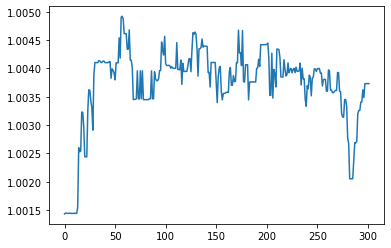

In [20] used 3.9336 MiB RAM in 0.37s, peaked 0.00 MiB above current, total RAM usage 2440.89 MiB


In [20]:
def make_wap(df):
    df['wap_num'] = (df['bid_price1'] * df['ask_size1']) + (df['ask_price1'] * df['bid_size1']) 
    df['wap_denom'] = df['bid_size1'] + df['ask_size1']
    df['wap'] = df['wap_num'] / df['wap_denom']
make_wap(book_example)
book_example.query('stock_id==0 and time_id==5')['wap'].plot()

In [21]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

book_example.loc[:,'log_return'] = log_return(book_example['wap'])
book_example = book_example[~book_example['log_return'].isnull()]
realized_vol = realized_volatility(book_example['log_return'])
realized_vol

0.004499364172786558

In [21] used -3.3789 MiB RAM in 0.12s, peaked 3.38 MiB above current, total RAM usage 2437.51 MiB


In [22]:
#df_book_data = df_book_train

In [22] used 0.0078 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 2437.52 MiB


In [23]:
df_book_train.shape

(45641526, 11)

In [23] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 2437.52 MiB


In [29]:
def realized_volatility_per_time_id(file_path, prediction_column_name, df_book_data):
    #df_book_data = pd.read_parquet(file_path)
    print('starting')
    df_book_data['wap_numer'] = (df_book_data['bid_price1'] * df_book_data['ask_size1']+df_book_data['ask_price1'] * df_book_data['bid_size1'])
    df_book_data['wap_denom'] = df_book_data['bid_size1'] + df_book_data['ask_size1']
    print("2", datetime.datetime.now())
    df_book_data['wap'] =  df_book_data['wap_numer'] / df_book_data['wap_denom']
    print('3', datetime.datetime.now())
    df_book_data['log_return'] = df_book_data.groupby(['stock_id', 'time_id'])['wap'].apply(log_return)
    print('4', datetime.datetime.now())
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
    print('5', datetime.datetime.now())
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['stock_id', 'time_id'])['log_return'].agg(realized_volatility)).reset_index()
    print('6', datetime.datetime.now())
    df_realized_vol_per_stock = df_realized_vol_per_stock.set_index(['stock_id', 'time_id'])
    return df_realized_vol_per_stock
    #df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    #stock_id = file_path.split('=')[1]
    #df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    #return df_realized_vol_per_stock[['row_id',prediction_column_name]]

# returns [stock_id, time_id, log_return]
feature_log_return = realized_volatility_per_time_id(None, 'target', df_book_train)

starting
2 2021-08-02 12:50:01.025970
3 2021-08-02 12:50:01.203982


KeyboardInterrupt: 

In [29] used 2496.1367 MiB RAM in 1228.35s, peaked 3427.59 MiB above current, total RAM usage 16165.77 MiB


In [ ]:
df_book_train

In [ ]:
feature_log_return

In [ ]:
features_var1

In [ ]:
df_book_train.head()

In [ ]:
#cols = ['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1']

cols = ['bid_price1', 'ask_price1']
#, 'log_return']
#cols = ['wap']

features_var1 = make_features1(df_book_train, 'var', cols)
print(f"{features_var1.memory_usage().sum() / 1_000_000:0.1f} MB")
features_var1

In [ ]:
features_mean1 = make_features1(df_book_train, 'mean', cols)
features_mean1

# Merge

In [ ]:
train_merged = pd.merge(df_train_all, features_var1, left_index=True, right_index=True)
train_merged = pd.merge(train_merged, features_mean1, left_index=True, right_index=True)
train_merged = pd.merge(train_merged, feature_log_return, left_index=True, right_index=True)


train_merged

In [ ]:
features = train_merged.drop(columns='target').columns
features

In [ ]:
chs = []
for feature in features:
    print(f"Making {feature}")
    df_sample = train_merged.reset_index().sample(5_00)
    chs.append(alt.Chart(df_sample).mark_point().encode(x=alt.X(feature, scale=alt.Scale(zero=False)), y='target'))
    
# https://altair-viz.github.io/user_guide/compound_charts.html
alt.vconcat(*chs)

In [ ]:
train_merged.reset_index()

In [ ]:
def train_test_split(df, target_col, time_ids_train, time_ids_test):
    X_train = df.query('time_id in @time_ids_train').drop(columns=[target_col, 'time_id'])
    X_test = df.query('time_id in @time_ids_test').drop(columns=[target_col, 'time_id'])
    y_train = df.query('time_id in @time_ids_train')[target_col]
    y_test = df.query('time_id in @time_ids_test')[target_col]
    return X_train, X_test, y_train, y_test

feature_cols = list(features) + ['stock_id']
X_train, X_test, y_train, y_test = train_test_split(train_merged.reset_index()[feature_cols+['time_id', 'target']], 'target', time_ids_train, time_ids_test)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
X_train.head(3)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# ML on a train/test split

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#est = LinearRegression()
est = RandomForestRegressor(n_estimators=10) # default n_estimators==100

In [ ]:
est.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import r2_score

print(f"{df_train_all.reset_index().stock_id.unique().shape[0]} unique stock ids, test set is {TEST_SIZE*100:0.1f}%")
print(f"Features:", feature_cols)
y_pred = est.predict(X_test)
score = r2_score(y_test, y_pred)
print(f"r^2 score {score:0.3f} on {y_pred.shape[0]:,} predictions")

In [ ]:
df_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
df_preds['abs_diff'] = (df_preds['y_test'] - df_preds['y_pred']).abs()
df_preds.sort_values('abs_diff', ascending=False)

In [ ]:
alt.Chart(df_preds.sample(500)).mark_bar().encode(
    alt.X("abs_diff:Q", bin=True),
    y='count()',)

In [ ]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(est, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()              

In [ ]:
from yellowbrick.regressor import PredictionError
visualizer = PredictionError(est)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
ax_subplot = visualizer.show()              
#ax_subplot.set_ylim((-0.25, 0.25))
#import matplotlib.pyplot as plt
#plt.draw()

In [ ]:
if 'feature_importances_' in dir(est):
    feature_col = 'feature_importances_'
if 'coef_' in dir(est):
    feature_col = 'coef_'
df_features = pd.DataFrame(zip(getattr(est, feature_col), feature_cols), columns=['importance', 'feature']).set_index('importance')
df_features.sort_index(ascending=False)